<a href="https://colab.research.google.com/github/AmirHDehghan/AI_MED_Internship/blob/main/CycleGan/MyFirstCycleGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from torch.utils.data import Dataset, DataLoader
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
#print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [2]:
# Batch size during training
batch_size = 1

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# The point that LR starts to decay
decay_epoch = 100


In [3]:
train_data = dset.MNIST(root = './data', train = True,
                        transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]), download = True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

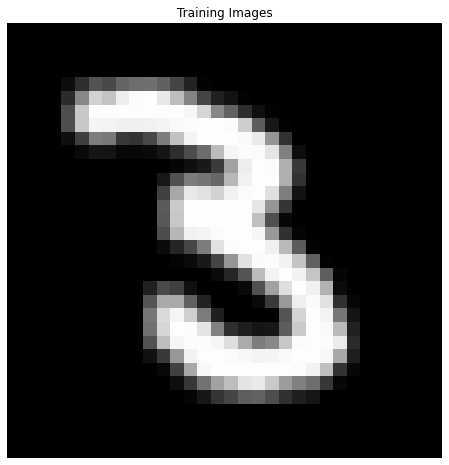

In [ ]:
# Plot some training images
#transforms.functional.crop(test_loader,0,0,14,14)
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator,self).__init__()
    
    self.ngpu = ngpu
    self.encoder = nn.Sequential(
        # nn.ReflectioanPad2d(3),
        nn.Conv2d(1, 64, 7, 1, 3),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        # nn.ReflectioanPad2d(1),
        nn.Conv2d(64, 128, 3, 2, 1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        # nn.ReflectioanPad2d(3),
        nn.Conv2d(128, 256, 3, 2, 1),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True)
    )

    self.transformer = nn.Sequential(
        
        # nn.ReflectioanPad2d(1),
        nn.Conv2d(256, 256, 3, 1, 1),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True)

    )

    self.decoder = nn.Sequential(
        
        # nn.ReflectioanPad2d(1),
        nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        # nn.ReflectioanPad2d(1),
        nn.ConvTranspose2d(128 , 64, 3, 2, 1, output_padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        # nn.ReflectioanPad2d(3),
        nn.Conv2d(64, 1, 7, 1, 3),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True)

    )

  def forward(self, input):
    
    self.encoded = self.encoder(input)
    self.transformed = self.transformer(self.encoded)
    
    for t in range(5):
      self.transformed = self.transformer(self.transformed)
    
    self.decoded = self.decoder(self.transformed)

    return self.decoded

In [6]:
class PatchGanDis(nn.Module):
  def __init__(self, ngpu):
    super(PatchGanDis,self).__init__()

    self.ngpu = ngpu
    self.main = nn.Sequential(
        
        # nn.ReflectionPad2d(1),
        nn.Conv2d(1, 64, 4, 2, 1),
        nn.InstanceNorm2d(64),
        nn.LeakyReLU(0.01, inplace= False),
                
        # nn.ReflectionPad2d(1),
        nn.Conv2d(64, 128, 4, 2, 1),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.01, inplace= False),
                
        # nn.ReflectionPad2d(1),
        nn.Conv2d(128, 256, 4, 2, 1),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.01, inplace= False),
                
        # nn.ReflectionPad2d(1),
        nn.Conv2d(256, 512, 4, 2, 1),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.01, inplace= False),

    )

  def forward(self, input):
    # print(input.shape)
    # yy = self.main(input)
    # print(yy.shape)
    return self.main(input)

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [9]:
# Create the generator
netG_a2b = Generator(ngpu).to(device)
netG_b2a = Generator(ngpu).to(device)

netPGD_a2b = PatchGanDis(ngpu).to(device)
# netPGD_b2a = PatchGanDis(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG_a2b.apply(weights_init_normal)
netG_b2a.apply(weights_init_normal)
netPGD_a2b.apply(weights_init_normal)
# netPGD_b2a.apply(weights_init_normal)

if torch.cuda.is_available():
    netG_a2b.cuda()
    netG_b2a.cuda()
    netPGD_a2b.cuda()
    # netPGD_b2a.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


In [10]:
class LambdaLR():
    def __init__(self, num_epochs, decay_start_epoch):
        assert ((num_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.num_epochs = num_epochs
        self.decay_start_epoch = decay_start_epoch

    def step(self, training_epoch):  # training_epoch : the right-now iteration number of epoch 
        return 1.0 - max(0, training_epoch - self.decay_start_epoch)/(self.num_epochs - self.decay_start_epoch)


In [11]:
# Initializing Loss!
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
# criterion_identity = torch.nn.L1Loss()


real_label = torch.ones(2,2)
fake_label = torch.zeros(2,2)

# Optimizer Initialization
OptimizerG_a2b = optim.Adam(netG_a2b.parameters(), lr=lr, betas=(beta1,0.999))
OptimizerPGD_a2b = optim.Adam(netPGD_a2b.parameters(), lr=lr, betas=(beta1,0.999))
OptimizerG_b2a = optim.Adam(netG_b2a.parameters(), lr=lr, betas=(beta1,0.999))
# OptimizerPGD_b2a = optim.Adam(netPGD_b2a.parameters(), lr=lr, betas=(beta1,0.999))



lr_scheduler_G_a2b = torch.optim.lr_scheduler.LambdaLR(OptimizerG_a2b, lr_lambda=LambdaLR(num_epochs, decay_epoch).step)
lr_schedulerPGD_a2b = torch.optim.lr_scheduler.LambdaLR(OptimizerPGD_a2b, lr_lambda=LambdaLR(num_epochs, decay_epoch).step)
lr_schedulerG_b2a = torch.optim.lr_scheduler.LambdaLR(OptimizerG_b2a, lr_lambda=LambdaLR(num_epochs, decay_epoch).step)
# lr_schedulerPGD_b2a = torch.optim.lr_scheduler.LambdaLR(OptimizerPGD_b2a, lr_lambda=LambdaLR(num_epochs, decay_epoch).step)


In [ ]:
# generated_noises = torch.randn(1,1,32,32)
# generated_noises.shape

torch.Size([1, 1, 32, 32])

In [16]:
#Training Phase

# Keeping Track...

img_list= []
Dlosses= []
Glosses= []
Cycle_losses= []

iters= 0

# The Loop:
for epoch in range(num_epochs):
  # Each epoch:
  for i, image in enumerate(train_loader,0):

    real_cpu = image[0].to(device)
    b_size = real_cpu.size(0)
    # label = torch.full((b_size,),real_label,dtype=torch.float,device=device)
    generated_noise = torch.randn(1,1,32,32)

    # PatchGan Discriminator
    # Update Real Batch
    netPGD_a2b.zero_grad()
    output = netPGD_a2b(real_cpu)
    rb_Dloss = criterion_GAN(output, real_label)
    rb_Dloss.backward()

    # Update Fake Batch
    fake = netG_a2b(generated_noise)
    output = netPGD_a2b(fake.detach())
    fb_Dloss = criterion_GAN(output, fake_label)
    fb_Dloss.backward()

    Dloss = fb_Dloss + rb_Dloss

    OptimizerPGD_a2b.step()

    # Generating fake image from noise AND computing MSE:
    netG_a2b.zero_grad()
    # fake_image = netG_a2b(generated_noise)
    output = netPGD_a2b(fake)
    Gloss = criterion_GAN(output, real_label) 
    Gloss.backward()

    OptimizerG_a2b.step()

    # Update b2a
    netG_b2a.zero_grad()
    recoverd_noise = netG_b2a(fake.detach())
    cycle_loss = criterion_cycle(recoverd_noise, generated_noise)
    cycle_loss.backward()

    OptimizerG_b2a.step()
    #if i % 50 == 0:
     #       print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
      #            % (epoch, num_epochs, i, len(train_loader),
       #              errD.item(), errG.item()))
    # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
    #         with torch.no_grad():
    #             fake = netG(fixed_noise,real_cpu_half).detach().to(device)
    #         img_list.append(vutils.make_grid(torch.cat([fake,real_cpu[:,:,:,32:]],dim=3), padding=2, normalize=True).tolist())
    #score = calculate_inception_score(asarray([imagel,fake.tolist()]))
    #print("score of inception:",score)
    print('[%d/%d][%d/%d]\tLoss_PGD: %.4f\tLoss_G_a2a: %.4f\tCycle_Loss: %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     Dloss.item(), Gloss.item(), cycle_loss.item()))

    iters += 1
    
    
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())
    Cycle_losses.append(cycle_loss.item())   
    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([2, 2])) that is different to the input size (torch.Size([1, 512, 2, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[0/200][0/60000]	Loss_PGD: 1.1228	Loss_G_a2a: 0.5636	Cycle_Loss: 0.9339
[0/200][1/60000]	Loss_PGD: 1.1292	Loss_G_a2a: 0.5754	Cycle_Loss: 0.9391
[0/200][2/60000]	Loss_PGD: 1.1056	Loss_G_a2a: 0.5541	Cycle_Loss: 0.9750
[0/200][3/60000]	Loss_PGD: 1.1161	Loss_G_a2a: 0.5655	Cycle_Loss: 0.9358
[0/200][4/60000]	Loss_PGD: 1.1107	Loss_G_a2a: 0.5669	Cycle_Loss: 0.9266
[0/200][5/60000]	Loss_PGD: 1.1164	Loss_G_a2a: 0.5638	Cycle_Loss: 0.9263
[0/200][6/60000]	Loss_PGD: 1.1038	Loss_G_a2a: 0.5657	Cycle_Loss: 0.8864
[0/200][7/60000]	Loss_PGD: 1.1154	Loss_G_a2a: 0.5729	Cycle_Loss: 0.8894
[0/200][8/60000]	Loss_PGD: 1.0961	Loss_G_a2a: 0.5581	Cycle_Loss: 0.9063
[0/200][9/60000]	Loss_PGD: 1.0899	Loss_G_a2a: 0.5624	Cycle_Loss: 0.8835
[0/200][10/60000]	Loss_PGD: 1.1110	Loss_G_a2a: 0.5590	Cycle_Loss: 0.8582
[0/200][11/60000]	Loss_PGD: 1.0819	Loss_G_a2a: 0.5545	Cycle_Loss: 0.8736
[0/200][12/60000]	Loss_PGD: 1.0800	Loss_G_a2a: 0.5528	Cycle_Loss: 0.8939
[0/200][13/60000]	Loss_PGD: 1.0778	Loss_G_a2a: 0.5594	Cycle_L

KeyboardInterrupt: ignored

In [30]:
for h in range(64):
  imgg = netG_a2b(generated_noise).detach()
  img_list.append(vutils.make_grid(imgg, padding=2, normalize=True).tolist())

In [37]:
img_list = []

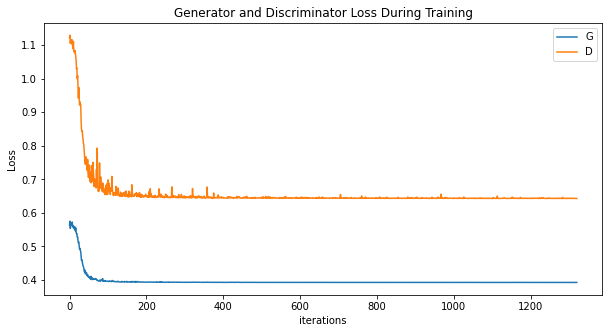

In [20]:
#  Plotting the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(Glosses,label="G")
plt.plot(Dlosses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

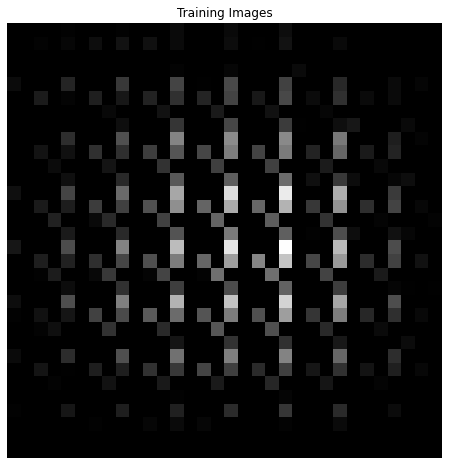

In [36]:

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(img_list[5]))

ValueError: ignored

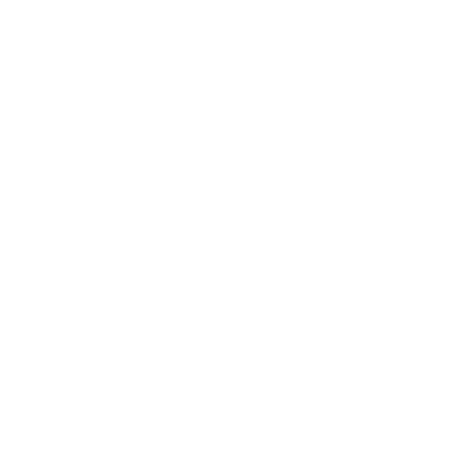

In [25]:
#Visualization of G’s progression
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.detach().numpy(),(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())